In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

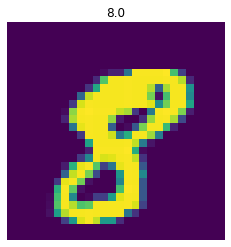

In [12]:
train = pd.read_csv(r"./Dataset/train.csv", dtype=np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:, train.columns != "label"].values/255

features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42)

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Softmax()
        )
    def forward(self, x):
        return self.mlp(x)

In [14]:
input_dim = 28*28
output_dim = 10

net = MLP(input_dim, output_dim)
loss_fn = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [17]:
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    labels = []
    labels_preds= []
    for image, label in data_loader:
        image = image.to(device)
        label = label.to(device)
        with torch.no_grad():
            _, label_pred = net(image).max(1)
        labels.append(label)
        labels_preds.append(label_pred)

    labels = torch.cat(labels)
    labels_preds = torch.cat(labels_preds)

    # CSVファイルを吐き出さなければいけない
    # 推論したラベルはlabelsに入ってる。画像のIDは知らない

    acc = (labels == labels_preds).float().sum() / len(labels)
    return acc

In [ ]:
def train_net(net, train_loader, test_loader, optimizer, loss_fn, n_iters=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    for epoch in range(n_iters):
        running_loss = 0.
        net.train()
        n = 0
        srore = 0

        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            # _, label_pred = net(images).max(1)
            label_pred = net(images)
            # print(images.shape)
            # print(labels.shape)
            # print(label_pred.shape)
            loss = loss_fn(label_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(images)
        train_losses.append(running_loss / len(train_loader))
        # train_acc.append(n_a)
        val_acc.append(eval_net(net, test_loader, device))
        print(epoch, train_losses[-1], val_acc[-1], flush=True)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(device)

train_net(net, train_loader, test_loader, optimizer=optimizer, loss_fn=loss_fn, n_iters=20, device=device)


In [ ]:
test = pd.read_csv(r"./Dataset/test.csv", dtype=np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
# targets_test = test.label.values
features_test = test.values/255

# features_train, features_test, targets_train, targets_test = train_test_split(
#     features_numpy, targets_numpy, test_size=0.2, random_state=42)


# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTest = torch.from_numpy(features_test)

# Pytorch train and test sets
# train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest)

# data loader
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [ ]:
def prediction(data_loader, device='cpu'):
    net.eval()
    test_pred = torch.LongTensor()

    for i, images in enumerate(data_loader):
        # print(images[0].size())
        images = images[0].to(device)
        output = net(images)
        _, pred = output.cpu().data.max(1, keepdim=True)
        test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [ ]:
test_pred = prediction(test_loader, device=device)
# print(test_pred)

out_df = pd.DataFrame(np.c_[np.arange(1, len(test)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

out_df.head()
out_df.to_csv('submission.csv', index=False)